In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import vectormath as vmath

from pyquaternion import Quaternion
from scipy.signal import savgol_filter

In [3]:
df_full = pd.read_csv('../my_data_processing/20220302Full-tilt/data/20220302Full-tilt-quaternion.csv')
df = df_full.iloc[15000:34400,:]

In [4]:
df

,Frame,Sub Frame,Diabolo-RX,Diabolo-RY,Diabolo-RZ,Diabolo-RW,Diabolo-TX,Diabolo-TY,Diabolo-TZ,stick_left-RX,...,stick_left-TX,stick_left-TY,stick_left-TZ,stick_right-RX,stick_right-RY,stick_right-RZ,stick_right-RW,stick_right-TX,stick_right-TY,stick_right-TZ
15000,15001,0,0.514905,0.478440,0.019596,0.711044,-309.946259,751.387329,495.335480,-0.010195,...,-413.098358,701.136963,979.300659,-0.485218,0.006275,0.192512,0.852915,-205.159988,724.131287,1470.387329
15001,15002,0,0.591665,0.423565,0.138819,0.671755,-314.118774,749.735596,502.981079,-0.011622,...,-412.917236,701.273560,979.119202,-0.478580,0.004912,0.192200,0.856736,-204.208817,722.109375,1474.996582
15002,15003,0,0.640854,0.326704,0.229940,0.655513,-312.205048,750.657776,502.632751,-0.012204,...,-412.461884,701.279175,979.262512,-0.474369,0.002747,0.189243,0.859740,-203.175751,720.458862,1478.932495
15003,15004,0,0.684189,0.238915,0.326892,0.606586,-313.746826,750.540161,506.090576,-0.011857,...,-411.785156,701.385559,979.362183,-0.470440,0.001507,0.191231,0.861461,-202.593079,718.882385,1482.612183
15004,15005,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012356,...,-411.321777,701.383789,979.511719,-0.465965,-0.001075,0.189856,0.864194,-201.814835,717.071594,1486.516846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34395,34396,0,0.197587,-0.703052,-0.603478,-0.320143,-407.446472,186.596863,493.113586,-0.700523,...,-389.239838,56.891495,1133.772705,-0.314424,-0.420691,0.839833,0.137247,-431.495911,375.488495,1329.685059
34396,34397,0,0.122767,-0.722751,-0.629280,-0.258002,-408.207001,186.765762,493.592743,-0.701106,...,-389.313812,56.811768,1133.612183,-0.314331,-0.420341,0.840032,0.137319,-431.592651,375.548828,1329.756592
34397,34398,0,0.070240,-0.735972,-0.648717,-0.180497,-404.741028,185.131042,494.495422,-0.700388,...,-389.434570,56.930820,1133.862183,-0.314104,-0.419868,0.840312,0.137570,-431.653778,375.639740,1329.849365
34398,34399,0,-0.004227,-0.736429,-0.665551,-0.121227,-405.792023,185.426010,493.491272,-0.700886,...,-389.441284,56.830509,1133.750610,-0.314425,-0.419944,0.840174,0.137450,-431.802490,375.645477,1329.760986


In [5]:
for column in df.columns:
    try:
        if column.split('-')[1][0] == 'T':
            df[column] = df[column]/1000
    except:
        print('oops')

oops
oops


C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_2708/601471971.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column]/1000


In [6]:
'''
Steps:
1. Get predictions of position and angular speed from Drigalski et al.
2. Predict pitch based on stick offset and angular speed
3. Get difference between predicted and actual (class value)
4. Create the training and testing datasets
5. Preprocess like I would for other ML datasets
'''

'\nSteps:\n1. Get predictions of position and angular speed from Drigalski et al.\n2. Predict pitch based on stick offset and angular speed\n3. Get difference between predicted and actual (class value)\n4. Create the training and testing datasets\n5. Preprocess like I would for other ML datasets\n'

In [7]:
# 1. Get predictions of position and angular speed from Drigalski et al.
# import library?
from diabolo_motion_classes import *

In [8]:
# starting values
# Diabolo-RX,Diabolo-RY,Diabolo-RZ,Diabolo-RW,Diabolo-TX,Diabolo-TY,Diabolo-TZ,
# stick_left-RX,stick_left-RY,stick_left-RZ,stick_left-RW,stick_left-TX,stick_left-TY,stick_left-TZ,
# stick_right-RX,stick_right-RY,stick_right-RZ,stick_right-RW,stick_right-TX,stick_right-TY,stick_right-TZ
# and the parameters for that file for testing
# Stick right
# Rotation: wxyz, Position: xyz
stick_right_inital_orientation = MyQuaternion(
    df.iloc[0,:]['stick_right-RW'], 
    df.iloc[0,:]['stick_right-RX'], 
    df.iloc[0,:]['stick_right-RY'], 
    df.iloc[0,:]['stick_right-RZ'])
stick_right_inital_position = vmath.Vector3(
    df.iloc[0,:]['stick_right-TX'], 
    df.iloc[0,:]['stick_right-TY'], 
    df.iloc[0,:]['stick_right-TZ'])
stick_right_pose = Pose(stick_right_inital_position, stick_right_inital_orientation)
# Diabolo
diabolo_inital_orientation = MyQuaternion(
    df.iloc[0,:]['Diabolo-RW'], 
    df.iloc[0,:]['Diabolo-RX'], 
    df.iloc[0,:]['Diabolo-RY'], 
    df.iloc[0,:]['Diabolo-RZ'])
diabolo_inital_position = vmath.Vector3(
    df.iloc[0,:]['Diabolo-TX'], 
    df.iloc[0,:]['Diabolo-TY'], 
    df.iloc[0,:]['Diabolo-TZ'])
diabolo_pose = Pose(diabolo_inital_position, diabolo_inital_orientation)
# Stick left
stick_left_inital_orientation = MyQuaternion(
    df.iloc[0,:]['stick_left-RW'], 
    df.iloc[0,:]['stick_left-RX'], 
    df.iloc[0,:]['stick_left-RY'], 
    df.iloc[0,:]['stick_left-RZ'])
stick_left_inital_position = vmath.Vector3(
    df.iloc[0,:]['stick_left-TX'], 
    df.iloc[0,:]['stick_left-TY'], 
    df.iloc[0,:]['stick_left-TZ'])
stick_left_pose = Pose(stick_left_inital_position, stick_left_inital_orientation)

# initial_poses: PoseArray: diabolo, left, right
initial_poses = PoseArray([diabolo_pose, stick_left_pose, stick_right_pose])

rot_velocity = 58.010031855847146 # the approx starting value I got from my analysis

trans_velocity = vmath.Vector3(0,0,0) # it looks like this is the default

# pull velocity scale
pv_pre_cap_scale = 0.13
pv_post_cap_scale = 0.13	
pv_cap_scale = 0.07

velocity_diffusion_factor = 0.9999
time_step = 1/600
caps_valid = False
mass = 0.2 # kg
axle_radius = 0.0065
string_length = 1.58 # meters
file_name = "data.csv"

initial_state = DiaboloSimConfig(
    initial_poses,
    rot_velocity,
    trans_velocity, 
    pv_pre_cap_scale, 
    pv_cap_scale,
    pv_post_cap_scale,
    velocity_diffusion_factor,
    time_step,
    caps_valid,
    mass,
    axle_radius,
    string_length,
    file_name
)

print(initial_state)

['+0.711 +0.515i +0.478j +0.020k [-0.30994626  0.75138733  0.49533548]', '-0.067 -0.010i +0.773j +0.631k [-0.41309836  0.70113696  0.97930066]', '+0.853 -0.485i +0.006j +0.193k [-0.20515999  0.72413129  1.47038733]'] 58.010031855847146 [0. 0. 0.] 0.13 0.07 0.13 0.9999 0.0016666666666666668 False 0.2 0.0065 1.58 data.csv


In [9]:
def generate_stick_poses_from_df(df):
    stick_right_poses = PoseArray([])
    stick_left_poses = PoseArray([])
    times = []
    for i in range(len(df)):
        row = df.iloc[i]
        stick_right_pose = Pose(
            vmath.Vector3(
                row['stick_right-TX'],
                row['stick_right-TY'],
                row['stick_right-TZ']
            ), MyQuaternion(
                x = row['stick_right-RX'],
                y = row['stick_right-RY'],
                z = row['stick_right-RZ'],
                w = row['stick_right-RW']
            ))
        stick_left_pose = Pose(
            vmath.Vector3(
                row['stick_left-TX'],
                row['stick_left-TY'],
                row['stick_left-TZ']
            ), MyQuaternion(
                x = row['stick_left-RX'],
                y = row['stick_left-RY'],
                z = row['stick_left-RZ'],
                w = row['stick_left-RW']
            ))
        stick_right_poses.poses.append(stick_right_pose)
        stick_left_poses.poses.append(stick_left_pose)
        times.append((row['Frame'] - df.iloc[0]['Frame']) * time_step)
    return stick_left_poses, stick_right_poses, times

In [10]:
stick_left_poses, stick_right_poses, times = generate_stick_poses_from_df(df)

steps = len(stick_left_poses.poses)
planned_left_times = []
planned_right_times = []
for i in range(1, steps + 1):
    planned_left_times.append(i * time_step)
    planned_right_times.append(i * time_step)

dp = DiaboloPredictor(initial_state)
print(dp.initial_state_.initial_poses.poses[0])
predicted_states = []
# dp.constrain_to_2D_flag = True
try:
    dp.predict(stick_left_poses, stick_right_poses, planned_left_times, planned_right_times, predicted_states, True)
except ValueError as e:
    print(e)

with open('output.csv', 'w') as f:
    f.write("X,Y,Z,W\n")
    for i in range(len(predicted_states)):
        position = predicted_states[i].pose.position
        rotational_velocity = predicted_states[i].rot_velocity
        f.write(f"{position.x},{position.y},{position.z},{rotational_velocity}\n")

+0.711 +0.515i +0.478j +0.020k [-0.30994626  0.75138733  0.49533548]


In [11]:
df_output = pd.read_csv('output.csv')

In [12]:
error = 0
for i in range(min(len(df), len(df_output))):
    if not np.isnan(df.iloc[i]['Diabolo-TX']) and not np.isnan(df_output.iloc[i]['X']):
        error += df.iloc[i]['Diabolo-TX'] - df_output.iloc[i]['X']
    if i %1000 == 0:
        print(df.iloc[i]['Diabolo-TX'], df_output.iloc[i]['X'])

-0.309946259 -0.309946259
-0.42867453 -0.7453831918488285
-0.472774841 -0.6029739342282812
-0.516531067 -0.6542768083983406
-0.525895752 -0.3429917298888593
-0.582484497 -0.0905861862357676
-0.584849854 -0.0854448749168289
-0.44197128300000005 -0.4045799613871766
-0.350166229 -0.9546016841122096
-0.363963501 -0.811373695527366
-0.291703491 -0.6054717201511165
-0.300489197 -0.5758037381732288
-0.6580676879999999 -0.5528251332405592
-0.538776245 -0.2136181693236326
-0.505954193 -0.6882247986230673
-0.47660611 -0.7174711878002655
-0.478363068 -0.1514157905917018
-0.5161536250000001 -1.2563615550989966
-0.442107849 0.2238373082714366
nan -0.2724500829198262


In [13]:
pitch_angles = []
offset_angles = []
yaw_angles = []
for i in range(len(df_full)):
    line = df_full.iloc[i]
    q = MyQuaternion(
        x=line['Diabolo-RX'],
        y=line['Diabolo-RY'],
        z=line['Diabolo-RZ'],
        w=line['Diabolo-RW'])

    direction_vector = vmath.Vector3(q.rotate([0,0,1]))
    horizontal_vector = vmath.Vector3(direction_vector[0], direction_vector[1], 0)
    horizontal_vector = horizontal_vector.normalize()

    pitch_angle = math.acos(direction_vector.dot(horizontal_vector))
    if (direction_vector[2]<=0):
        pitch_angle *= -1
    pitch_angles.append(pitch_angle)

    stick_right_vector = vmath.Vector3(
        line['stick_right-TX'],
        line['stick_right-TY'],
        line['stick_right-TZ']
    )
    stick_left_vector = vmath.Vector3(
        line['stick_left-TX'],
        line['stick_left-TY'],
        line['stick_left-TZ']
    )

    stick_diff_vector = stick_right_vector - stick_left_vector
    stick_diff_vector = vmath.Vector3(stick_diff_vector[0], stick_diff_vector[1], 0)
    stick_diff_vector = stick_diff_vector.normalize()

    offset_angle = math.pi/2 - math.acos(stick_diff_vector.dot(horizontal_vector))
    offset_angles.append(-offset_angle)
    
    yaw = math.atan2(q.rotation_matrix[1,0],q.rotation_matrix[0,0])
    yaw_angles.append(yaw)

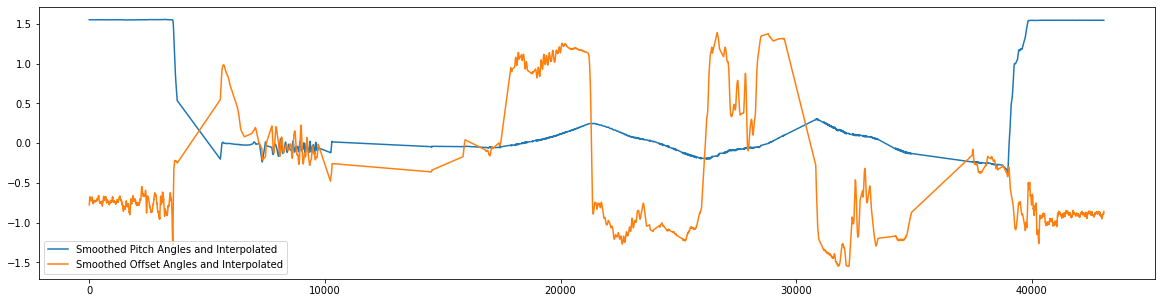

In [14]:
smoothed_pitch_angles = savgol_filter(pitch_angles, 101, 5)
x = smoothed_pitch_angles
xi = np.arange(len(x))
mask = np.isfinite(x)
xfiltered_pitch = np.interp(xi, xi[mask], x[mask])
plt.figure(figsize=(20,5))
plt.plot(list(range(len(xfiltered_pitch))), xfiltered_pitch, label="Smoothed Pitch Angles and Interpolated")

smoothed_offset_angles = savgol_filter(offset_angles, 101, 5)
x = smoothed_offset_angles
xi = np.arange(len(x))
mask = np.isfinite(x)
xfiltered_offset = np.interp(xi, xi[mask], x[mask])
plt.plot(list(range(len(xfiltered_offset))), xfiltered_offset, label="Smoothed Offset Angles and Interpolated")

plt.legend()

In [15]:
change_in_pitch = []
offset_angularspeed = []

for i in range(len(df)):
    time_index = i + 15000
    change_in_pitch.append((xfiltered_pitch[time_index+1] - xfiltered_pitch[time_index])/(1))
    offset_angularspeed.append(xfiltered_offset[time_index]/(df_output.iloc[i]['W']))


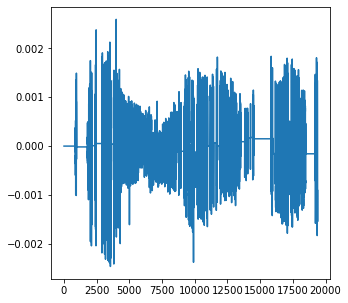

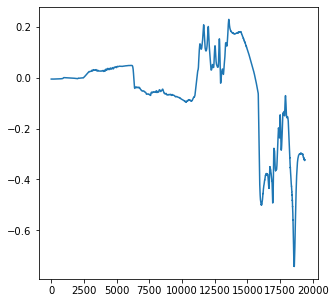

In [16]:
plt.figure(figsize=(5,5))
plt.plot(change_in_pitch)
plt.figure(figsize=(5,5))
plt.plot(offset_angularspeed)

In [17]:
ratio = np.array(change_in_pitch)/np.array(offset_angularspeed)

In [18]:
predicted_change_in_pitch = []
predicted_pitch = [xfiltered_pitch[15000]]

for i in range(len(df)):

    ratio_offset_speed = xfiltered_offset[i+15000]/(df_output.iloc[i]['W'])
    change_in_pitch_value = ratio_offset_speed * 0.0018583839918719272
    predicted_change_in_pitch.append(change_in_pitch_value)
    predicted_pitch.append(predicted_pitch[-1] + change_in_pitch_value)

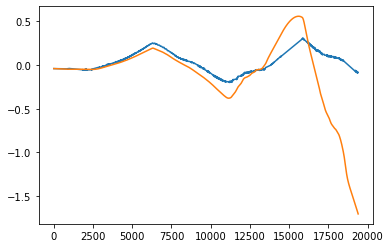

In [19]:
plt.plot(xfiltered_pitch[15005: 34393])
plt.plot(predicted_pitch)

In [20]:
len(xfiltered_pitch[15000:34400])

19400

In [21]:
with open('output_pitch.csv', 'w') as f:
    f.write("pitch,predicted_pitch\n")
    for i in range(len(xfiltered_pitch[15000:34400])):
        f.write(f"{xfiltered_pitch[15000+i]},{predicted_pitch[i]}\n")

In [23]:
yaw_angles = np.array(yaw_angles)
threshold_array = yaw_angles > 0
zero_one = []

for i in range(len(threshold_array)-1):
    if threshold_array[i] == 0 and threshold_array[i+1] == 1:
        zero_one.append(i)

periods = [zero_one[i+1] - zero_one[i] for i in range(len(zero_one)-1)]
smoothed_periods = savgol_filter(periods, 101, 5)

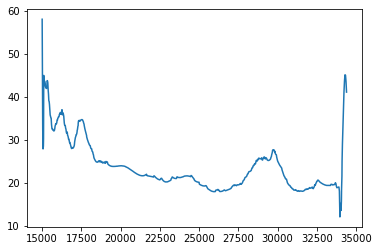

In [24]:
plt.plot(zero_one[158:915], 600/smoothed_periods[158:915])

In [33]:
smoothed_angular_speed_range = 600/smoothed_periods[157:916]

In [34]:
len(smoothed_angular_speed_range)

759

In [39]:
start = zero_one[157]
end = 34400
calculated_angular_speed = []
time_indices = zero_one[157:916]
i = 0
while start < end:
    if i >= len(smoothed_angular_speed_range) - 1:
        calculated_angular_speed.append(smoothed_angular_speed_range[-1])
    elif start < time_indices[i+1]:
        calculated_angular_speed.append(smoothed_angular_speed_range[i])
    else:
        i+=1
        calculated_angular_speed.append(smoothed_angular_speed_range[i])
    start+=1

In [47]:
calculated_angular_speed = calculated_angular_speed[4:]

In [48]:
with open('calculated_angular_speed.csv', 'w') as f:
    f.write("W\n")
    for i in range(len(calculated_angular_speed)):
        f.write(f"{calculated_angular_speed[i]}\n")